In [1]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from tqdm import tqdm
from langchain_openai import AzureOpenAIEmbeddings
import json
import numpy as np
import torch
import time
import random
import ast
import matplotlib.pyplot as plt
from collections import defaultdict

import os

/Users/olliglorioso/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/olliglorioso/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's fetch the dataframes.

In [2]:
from data_extractor import Extractor
extractor_instance = Extractor()
extractor_instance.extract(location="./data/results/df_combined.csv")

df_combined = pd.read_csv("data/results/df_combined.csv")
df_combined.sample(n=3)

Comp domain df length: 1912  - VTT domain df length: 4927
Example of text to compare: FiR 1 - FiR 1 is a Triga-type nuclear research reactor located in Otaniemi, Espoo, Finland, decommissioned by VTT after serving since 1962, used for nuclear research, training, and medical radiation therapy. | Developed by VTT Technical Research Centre of Finland Ltd.


,Unnamed: 0.1,Document number,VAT id,relationship description,source id,source type,source english_id,source description,relationship type,target id,target type,target english_id,target description,Link Source Text,Source Text,text_to_compare,Unnamed: 0,Source Company
4651,4651,VTT1259,FI08974643,The augmented reality tool was developed by VT...,a tool developed by VTT using augmented reality,Innovation,a tool developed by VTT using augmented reality,A tool developed by VTT using augmented realit...,DEVELOPED_BY,FI26473754,Organization,VTT Technical Research Centre of Finland Ltd,A visionary research and innovation partner an...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,a tool developed by VTT using augmented realit...,NaN,NaN
4299,4299,VTT1096,FI21630263,Teleste contributed as a consortium member in ...,LuxTurrim5G solution,Innovation,LuxTurrim5G solution,A digital backbone for cities comprising modul...,DEVELOPED_BY,FI11022678,Organization,Teleste,A member of the LuxTurrim5G consortium involve...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,LuxTurrim5G solution - A digital backbone for ...,NaN,NaN
2070,2070,VTT524,FI25530198,The UrbanMill industrial chemical recycling co...,industrial chemical recycling concept for plas...,Innovation,industrial chemical recycling concept for plas...,A sustainable industrial chemical recycling co...,DEVELOPED_BY,FI26473754,Organization,VTT Technical Research Centre of Finland,A leading European research organization coord...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,industrial chemical recycling concept for plas...,NaN,NaN


In [ ]:
from embedding_generator import EmbeddingGenerator, LocalEmbeddingProvider, OpenAIEmbeddingProvider

# Configuration
METHOD = "openai"  # Supports local and openai
MODEL_NAME = "all-mpnet-base-v2"  # For local embeddings
MODEL_KEY = "gpt-4.1-mini"  # For OpenAI embeddings, I think only this works

# File paths
input_file = "data/results/df_combined.csv"
output_file = "data/results/embeddings.csv"

provider = OpenAIEmbeddingProvider(MODEL_KEY) if METHOD == "openai" else LocalEmbeddingProvider(MODEL_NAME)
generator = EmbeddingGenerator(provider)

result_df = None
recreate_embeddings = False
if os.path.exists(output_file) and not recreate_embeddings:
    result_df = pd.read_csv(output_file)
    print(f"Loaded {len(result_df)} pairs from {output_file}")
else:
    result_df = generator.generate_embeddings(input_file, output_file)

result_df["embedding"] = result_df["embedding"].apply(ast.literal_eval)

2025-05-31 18:43:10,759 - INFO - Initialized OpenAI embedding model with key: gpt-4.1-mini


In [5]:
result_df.head()

,Unnamed: 0.1,Document number,VAT id,relationship description,source id,source type,source english_id,source description,relationship type,target id,...,target english_id,target description,Link Source Text,Source Text,text_to_compare,Unnamed: 0,Source Company,embedding,embedding_provider,embedding_dimension
0,0,VTT0,FI10292588,"FiR 1 nuclear research reactor was developed, ...",FiR 1,Innovation,FiR 1,FiR 1 is a Triga-type nuclear research reactor...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland Ltd.,VTT is a Finnish research and innovation partn...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,FiR 1 - FiR 1 is a Triga-type nuclear research...,NaN,NaN,"[-0.018910497426986694, 0.017533520236611366, ...",openai_gpt-4.1-mini,3072
1,1,VTT0,FI10292588,Centre for Nuclear Safety is being developed a...,Centre for Nuclear Safety,Innovation,Centre for Nuclear Safety,A modern research facility under construction ...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland Ltd.,VTT is a Finnish research and innovation partn...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Centre for Nuclear Safety - A modern research ...,NaN,NaN,"[-0.009751166217029095, 0.006150579079985619, ...",openai_gpt-4.1-mini,3072
2,2,VTT3,FI08932048,The innovation approach 'Beyond the obvious' i...,Beyond the obvious,Innovation,Beyond the obvious,An innovation approach promising to provide so...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland Ltd,A visionary research and innovation partner fo...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Beyond the obvious - An innovation approach pr...,NaN,NaN,"[-0.02210899069905281, -0.002120873425155878, ...",openai_gpt-4.1-mini,3072
3,3,VTT4,FI01111693,Data-Driven Bioeconomy project is developed by...,Data-Driven Bioeconomy project,Innovation,Data-Driven Bioeconomy project,An innovation using Big Data for sustainable u...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland,A Finnish research and innovation partner work...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Data-Driven Bioeconomy project - An innovation...,NaN,NaN,"[-0.015033945441246033, 0.031899139285087585, ...",openai_gpt-4.1-mini,3072
4,4,VTT4,FI01111693,Data-Driven Bioeconomy project's forestry pilo...,Data-Driven Bioeconomy project,Innovation,Data-Driven Bioeconomy project,An innovation using Big Data for sustainable u...,DEVELOPED_BY,temp_1141,...,MHG Systems,An organization leading pilots developing fore...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Data-Driven Bioeconomy project - An innovation...,NaN,NaN,"[-0.014490003697574139, 0.016991155222058296, ...",openai_gpt-4.1-mini,3072


In [6]:
def calculate_similar_pairs(embeddings_tensor, threshold=0.8, verbose=True):

    similar_pairs = []

    # Compute cosine similarity matrix
    cos_sim_matrix = util.cos_sim(embeddings_tensor, embeddings_tensor)

    # Get indices of upper triangle (i < j)
    triu_indices = torch.triu_indices(cos_sim_matrix.size(0), cos_sim_matrix.size(1), offset=1)

    # Get similarity scores for upper triangle
    sim_scores = cos_sim_matrix[triu_indices[0], triu_indices[1]]

    # Filter by threshold
    mask = sim_scores > threshold
    i_indices = triu_indices[0][mask].tolist()
    j_indices = triu_indices[1][mask].tolist()
    scores = sim_scores[mask].tolist()

    # Collect similar pairs
    similar_pairs = [(i, j, score) for i, j, score in zip(i_indices, j_indices, scores)]
    
    return similar_pairs, scores

def create_embeddings_tensor(duplicates=False):
    result_df_final = result_df.copy()
    if duplicates == False:
        result_df_final = result_df.drop_duplicates(subset=["source description"]).reset_index(drop=True)

    combined_embeddings = result_df_final["embedding"].tolist()
    combined_texts = result_df_final["text_to_compare"].tolist()

    start_time = time.time()
    embeddings_tensor = torch.stack([torch.tensor(e) for e in combined_embeddings])
    return embeddings_tensor, combined_texts, combined_embeddings, result_df_final

def save_duplicates(dup_df):
    duplicates = dup_df[dup_df.duplicated("source description", keep=False)]
    # Save to CSV
    duplicates.to_csv("data/results/duplicates.csv", index=False)
    print(len(duplicates), " was the length of duplicates in total")

    

Last datapoint: 27, 0.9940291532763729


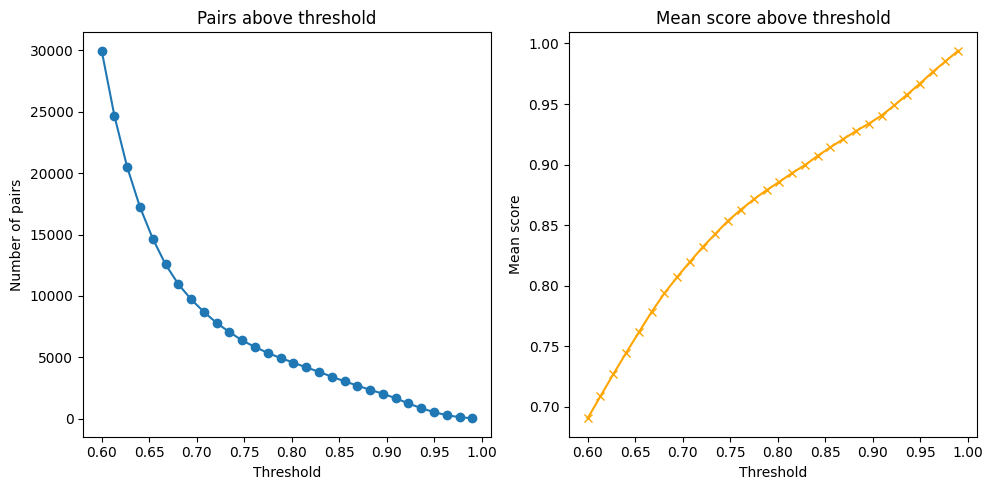

In [7]:
thresholds = np.linspace(0.6, 0.99, 30)
pair_counts = []
mean_scores = []

embeddings_tensor, combined_texts, combined_embeddings, mutated_result_df = create_embeddings_tensor()

for threshold in thresholds:
    similar_pairs, scores = calculate_similar_pairs(embeddings_tensor, threshold=threshold)
    pair_counts.append(len(similar_pairs))
    mean_scores.append(np.mean(scores) if scores else 0)

print(f"Last datapoint: {pair_counts[-1]}, {mean_scores[-1]}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(thresholds, pair_counts, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Number of pairs')
plt.title('Pairs above threshold')

plt.subplot(1, 2, 2)
plt.plot(thresholds, mean_scores, marker='x', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Mean score')
plt.title('Mean score above threshold')

plt.tight_layout()
plt.show()

# Let's group the pairs

In [8]:
def group_similar_pairs(similar_pairs):
    
    # Create adjacency list representation
    graph = defaultdict(set)
    
    # Build the graph from pairs
    for i, j, score in similar_pairs:
        graph[i].add(j)
        graph[j].add(i)
     
    # Find connected components using DFS
    visited = set()
    groups = []
    
    def dfs(node, current_group):
        if node in visited:
            return
        visited.add(node)
        current_group.add(node)
        
        # Visit all neighbors
        for neighbor in graph[node]:
            dfs(neighbor, current_group)
    
    # Find all connected components
    for node in graph:
        if node not in visited:
            current_group = set()
            dfs(node, current_group)
            if current_group:  # Only add non-empty groups
                groups.append(current_group)
    
    return groups



In [9]:
import random
similar_pairs, scores = calculate_similar_pairs(embeddings_tensor)
groups_sorted = group_similar_pairs(similar_pairs)
# Ensure there are at least 5 groups
num_samples = min(5, len(groups_sorted))
random_groups = random.sample(groups_sorted, num_samples)

print(f"\nSample of 10 random groups:")
for i, group in enumerate(random_groups):
    print(f"\nGroup {i+1} (size: {len(group)}):")
    for idx in sorted(group):
        print(f"  Index {idx}: {combined_texts[idx][:100]}...")


Sample of 10 random groups:

Group 1 (size: 5):
  Index 122: hydrogen-powered fuel cell system, which will act as an auxiliary power source on board the ship Ara...
  Index 123: fuel cell system developed in close cooperation with PowerCell - A hydrogen fuel cell system develop...
  Index 125: hydrogen-powered fuel cell system - A hydrogen-powered fuel cell system built by VTT as an auxiliary...
  Index 127: hydrogen-powered fuel cell system - A hydrogen-powered fuel cell system built by VTT for the researc...
  Index 249: VTT hydrogen fuel cell power plant for Aranda - Hydrogen-fueled fuel cell power plant being built by...

Group 2 (size: 2):
  Index 2345: polyurethane adhesives made without isocyanate using chemicals from carbon dioxide - Polyurethane ad...
  Index 2917: polyurethane adhesives without isocyanate - Adhesives manufactured from chemicals made from carbon d...

Group 3 (size: 2):
  Index 3419: Kalasataman plusenergiatalo - An eight-story apartment building in Kalasatam

Last datapoint: 26, 2.0384615384615383


<Figure size 1000x500 with 0 Axes>

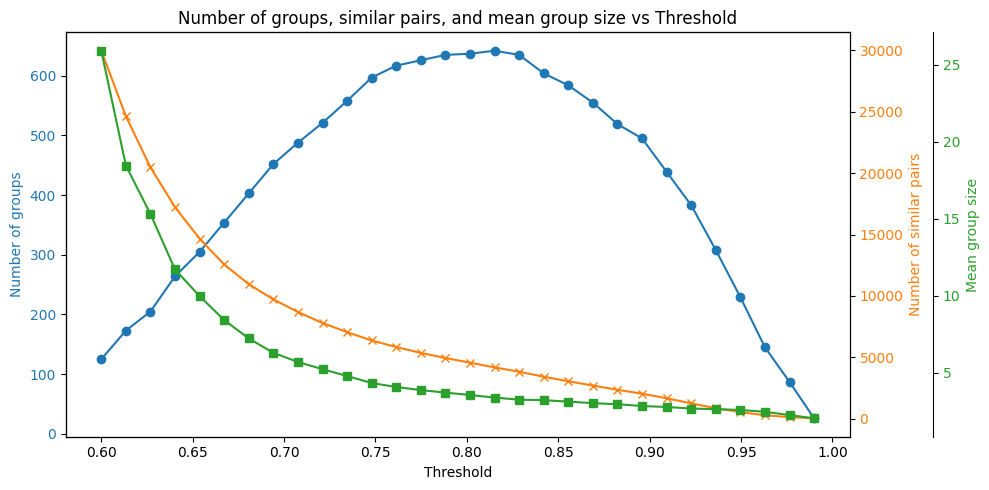

In [10]:
thresholds = np.linspace(0.6, 0.99, 30)
pair_counts = []
pair_sizes = []
mean_group_sizes = []

for threshold in thresholds:
    
    similar_pairs, scores = calculate_similar_pairs(embeddings_tensor, threshold)
    groups = group_similar_pairs(similar_pairs)
    pair_counts.append(len(groups))
    pair_sizes.append(len(similar_pairs))  # Track number of similar pairs
    if groups:
        mean_group_sizes.append(np.mean([len(g) for g in groups]))
    else:
        mean_group_sizes.append(0)

print(f"Last datapoint: {pair_counts[-1]}, {mean_group_sizes[-1]}")

plt.figure(figsize=(10, 5))
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of groups', color=color)
ax1.plot(thresholds, pair_counts, marker='o', color=color, label='Number of groups')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Number of similar pairs', color=color)
ax2.plot(thresholds, pair_sizes, marker='x', color=color, label='Number of similar pairs')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Mean group size', color=color)
ax3.plot(thresholds, mean_group_sizes, marker='s', color=color, label='Mean group size')
ax3.tick_params(axis='y', labelcolor=color)

plt.title('Number of groups, similar pairs, and mean group size vs Threshold')
fig.tight_layout()
plt.show()

# Let's create the final groups and grahp

In [11]:
embeddings_tensor, combined_texts, combined_embeddings, result_df_mutated = create_embeddings_tensor()

In [12]:
similar_pairs_final, scores_final = calculate_similar_pairs(embeddings_tensor, threshold=0.8)
print("original amount of rows", len(result_df))
save_duplicates(result_df)

original amount of rows       Unnamed: 0.1 Document number      VAT id  \
0                0            VTT0  FI10292588   
1                1            VTT0  FI10292588   
2                2            VTT3  FI08932048   
3                3            VTT4  FI01111693   
4                4            VTT4  FI01111693   
...            ...             ...         ...   
6834          6834        COMP1343         NaN   
6835          6835        COMP1344         NaN   
6836          6836        COMP1348         NaN   
6837          6837        COMP1348         NaN   
6838          6838        COMP1348         NaN   

                               relationship description  \
0     FiR 1 nuclear research reactor was developed, ...   
1     Centre for Nuclear Safety is being developed a...   
2     The innovation approach 'Beyond the obvious' i...   
3     Data-Driven Bioeconomy project is developed by...   
4     Data-Driven Bioeconomy project's forestry pilo...   
...                  

In [13]:
groups_final = group_similar_pairs(similar_pairs_final)

print(groups_final)

random_groups = random.sample(groups_final, 10)

print(f"\nSample of 10 random groups:")
for i, group in enumerate(random_groups):
    print(f"\nGroup {i+1} (size: {len(group)}):")
    for idx in sorted(group):
        print(f"  Index {idx}: {combined_texts[idx][:100]}...")

[{0, 2017, 1574, 1575, 1225, 3403, 3404, 1517, 942, 943, 816, 2645}, {233, 6}, {3107, 3110, 8, 9, 173, 2513}, {10, 11, 1195, 339, 1211}, {625, 37, 13}, {1136, 18, 15}, {19, 20, 236}, {3366, 839, 840, 1339, 27, 1340, 3006}, {30, 28, 29, 254, 255}, {2533, 1302, 89, 2650, 31}, {32, 33, 1476}, {35, 36, 1287}, {1155, 38}, {42, 43, 44, 45}, {155, 156, 46}, {450, 419, 1413, 198, 199, 47, 1205, 693, 663, 664, 1209}, {226, 53}, {57, 231, 230, 55}, {56, 270}, {1549, 407, 408, 798, 799, 800, 801, 440, 441, 59, 1596, 1731, 843, 844, 845, 846, 1742, 489, 492, 495, 503, 504, 505, 506}, {64, 65, 1633, 1634, 963, 1637, 962, 394, 490, 396, 397, 493, 1267, 1268, 60, 61}, {528, 524, 62, 63}, {67, 326}, {68, 135}, {69, 398, 399}, {3456, 3463, 72, 2164, 2713}, {3457, 3459, 3462, 73, 2710, 2166, 2715}, {3458, 3464, 74, 2165, 2712, 2714}, {2754, 2755, 2788, 2787, 2761, 2762, 1323, 76, 2795, 2796, 1305}, {1374, 78}, {1322, 79}, {80, 1275}, {162, 83, 84, 163}, {259, 87}, {88, 253}, {3153, 90, 562}, {1347, 92},

Now validate groups

In [14]:
from pydantic import BaseModel
from typing import List
from langchain_openai import AzureChatOpenAI
import asyncio
from langchain.schema import HumanMessage, SystemMessage
moi

class FalsePositives(BaseModel):
    innovations: List[int] = []

SYSTEM_PROMPT = """You are an expert innovation analyst. 

You will receive groups of innovations that were identified as potential duplicates based on similarity.

Your task: Identify which innovation numbers are NOT duplicates (distinct innovations).

Return only the numbers of innovations that represent different projects/technologies."""

def create_user_prompt(group_indices, combined_texts, result_df):
    """Create simple user prompt"""
    
    innovations_text = ""
    for i, idx in enumerate(sorted(group_indices), 1):
        innovation_text = combined_texts[idx]
        innovations_text += f"{i}. {innovation_text}\n\n"

    return f"""Which innovations are NOT duplicates?

{innovations_text}Return the numbers of distinct innovations."""

def initialize_llm(deployment_model:str, config_file_path:str= 'data/keys/azure_config.json')->AzureChatOpenAI: 
    with open(config_file_path, 'r') as jsonfile:
        config = json.load(jsonfile)
    
    return AzureChatOpenAI(model =deployment_model,
                    api_key=config[deployment_model]['api_key'],
                    azure_endpoint = config[deployment_model]['api_base'],
                    api_version = config[deployment_model]['api_version'])

# Initialize with structured output
llm = initialize_llm(deployment_model="gpt-4.1-mini").with_structured_output(FalsePositives)

async def evaluate_group(group, combined_texts, result_df):
    
    messages = [
        SystemMessage(content=SYSTEM_PROMPT),
        HumanMessage(content=create_user_prompt(group, combined_texts, result_df))
    ]
    
    result = await llm.ainvoke(messages)
    
    print(create_user_prompt(group, combined_texts, result_df))
    print("RESULT ----", result)

    return {
        "group_indices": list(group),
        "false_positives": result.innovations
    }

# Process all groups
async def evaluate_all_groups(groups, combined_texts, result_df):
    """Process all groups with 2+ innovations"""
    i = 0
    tasks = []
    for i, group in enumerate(groups):
        if len(group) >= 2:
            tasks.append(evaluate_group(group, combined_texts, result_df))            

    results = await asyncio.gather(*tasks)
    return results

NameError: name 'moi' is not defined

In [42]:
results = await evaluate_all_groups(groups_final, combined_texts, result_df)

# now we can see the results
for result in results:
   print(result)
   
with open("results.json", "w") as f:
   json.dump(results, f, indent=2)
   

2025-05-31 17:49:13,170 - INFO - HTTP Request: POST https://aaltoaihack25-resource.cognitiveservices.azure.com/openai/deployments/gpt-4.1-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-05-31 17:49:13,188 - INFO - HTTP Request: POST https://aaltoaihack25-resource.cognitiveservices.azure.com/openai/deployments/gpt-4.1-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-05-31 17:49:13,190 - INFO - HTTP Request: POST https://aaltoaihack25-resource.cognitiveservices.azure.com/openai/deployments/gpt-4.1-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-05-31 17:49:13,208 - INFO - HTTP Request: POST https://aaltoaihack25-resource.cognitiveservices.azure.com/openai/deployments/gpt-4.1-mini/chat/completions?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-05-31 17:49:13,210 - INFO - HTTP Request: POST https://aaltoaihack25-resource.cognitiveservices.azure.com/openai/deployments/gpt-4.1-mini/chat/completions?api-

Which innovations are NOT duplicates?

1. AARRE project - A networked research project (2015-2017) developing new user-driven circular economy business activities including novel logistics services. | Developed by VTT

2. AARRE-projekti - AARRE-projekti is a user-centered innovation for circular economy logistics developed to improve material flow efficiency, sharing of information, and cooperation between businesses and consumers. | Developed by VTT

Return the numbers of distinct innovations.
RESULT ---- innovations=[]
Which innovations are NOT duplicates?

1. bio-based packaging solution made of cellulose - A compostable and lightweight packaging material developed by combining cellulose films with different, complementary properties, suitable for dry and greasy products, which extends shelf life and reduces food waste and microplastics problem. | Developed by VTT Technical Research Centre of Finland

2. bio-based packaging solution - A compostable and lightweight packaging material